In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import time
import re

In [3]:
train_data_dir = '/opt/ml/input/data/train/'

In [4]:
train_rating = pd.read_csv(os.path.join(train_data_dir, 'train_ratings.csv'))
# item info
writers = pd.read_csv(os.path.join(train_data_dir, 'writers.tsv'), sep='\t')
director = pd.read_csv(os.path.join(train_data_dir, 'directors.tsv'), sep='\t')
title = pd.read_csv(os.path.join(train_data_dir, 'titles.tsv'), sep='\t')
genre = pd.read_csv(os.path.join(train_data_dir, 'genres.tsv'), sep='\t')
year = pd.read_csv(os.path.join(train_data_dir, 'years.tsv'), sep='\t')

In [5]:
train_rating

,user,item,time
0,11,4643,1230782529
1,11,170,1230782534
2,11,531,1230782539
3,11,616,1230782542
4,11,2140,1230782563
...,...,...,...
5154466,138493,44022,1260209449
5154467,138493,4958,1260209482
5154468,138493,68319,1260209720
5154469,138493,40819,1260209726


이 데이터에서 time은 유저가 평점을 남긴 시간을 나타내서 정말 유저가 이 영화를 봤는지는 알 수 없지만   
영화를 본 것이라고 가정함

In [6]:
print('유저 id',train_rating['user'].unique())
print('총 유저수', train_rating['user'].nunique())
print('모든 유저가 본 총 영화 수', train_rating['item'].nunique())

유저 id [    11     14     18 ... 138486 138492 138493]
총 유저수 31360
모든 유저가 본 총 영화 수 6807


- time 이 unix시간으로 나타나 있으므로 변경
- year 만 유의미할 것이라고 판단 (영화의 개봉연도만 제공하기 때문)

In [7]:
def change_time(t):
    return time.strftime('%Y-%m-%d', time.localtime(t))

In [8]:
train_rating['datetime'] = train_rating['time'].apply(change_time)
train_rating['datetime'] = pd.to_datetime(train_rating['datetime'])
train_rating['year'] = train_rating['datetime'].dt.year
train_rating

,user,item,time,datetime,year
0,11,4643,1230782529,2009-01-01,2009
1,11,170,1230782534,2009-01-01,2009
2,11,531,1230782539,2009-01-01,2009
3,11,616,1230782542,2009-01-01,2009
4,11,2140,1230782563,2009-01-01,2009
...,...,...,...,...,...
5154466,138493,44022,1260209449,2009-12-07,2009
5154467,138493,4958,1260209482,2009-12-07,2009
5154468,138493,68319,1260209720,2009-12-07,2009
5154469,138493,40819,1260209726,2009-12-07,2009


--------

## item infomation

### writer 작가

In [9]:
writers

,item,writer
0,1237,nm0000005
1,5147,nm0000005
2,7327,nm0000005
3,2068,nm0000005
4,7396,nm0000005
...,...,...
11301,27397,nm5371819
11302,2987,nm5927607
11303,33463,nm5927607
11304,2987,nm5927608


In [10]:
print(writers.shape)
print('결측치')
print(writers.isnull().sum())
print('영화 수',writers['item'].nunique())
print('작가 수', writers['writer'].nunique())


(11306, 2)
결측치
item      0
writer    0
dtype: int64
영화 수 5648
작가 수 2989


In [11]:
# 작가당 영화 참여수
writers['writer'].value_counts()

nm0000095    47
nm0000636    35
nm0000175    32
nm0372942    30
nm0000108    29
             ..
nm0414893     2
nm0414448     2
nm0414117     2
nm0414047     2
nm5927608     2
Name: writer, Length: 2989, dtype: int64

In [12]:
# 영화당 작가수
writers['item'].value_counts()

1907     24
783      23
364      21
2687     21
48322    19
         ..
79073     1
176       1
2560      1
42007     1
1237      1
Name: item, Length: 5648, dtype: int64

In [13]:
new_writers = writers.groupby(['item']).agg({'writer':'unique'})
new_writers

,writer
item,
1,"[nm0004056, nm0005124, nm0169505, nm0230032, n..."
2,"[nm0378144, nm0852430, nm0885575]"
3,[nm0425756]
4,[nm0060103]
5,"[nm0329304, nm0352443, nm0583600, nm0796124]"
...,...
118696,"[nm0001392, nm0101991, nm0866058, nm0868219, n..."
118900,[nm0394984]
118997,[nm0487567]


### director 감독

In [14]:
director

,item,director
0,1237,nm0000005
1,5147,nm0000005
2,7327,nm0000005
3,2068,nm0000005
4,7396,nm0000005
...,...,...
5900,84273,nm2879822
5901,58376,nm2879822
5902,65225,nm2879822
5903,2394,nm9054338


In [15]:
print(director.shape)
print('결측치')
print(director.isnull().sum())
print('영화 수',director['item'].nunique())
print('작가 수', director['director'].nunique())

(5905, 2)
결측치
item        0
director    0
dtype: int64
영화 수 5503
작가 수 1340


In [16]:
# 영화당 작가 수
director['item'].value_counts()

50912    14
1282     10
27002     8
7502      7
596       7
         ..
163       1
70        1
6566      1
5504      1
55768     1
Name: item, Length: 5503, dtype: int64

In [17]:
# 작가당 영화 수
director['director'].value_counts()

nm0000095    44
nm0000033    33
nm0000142    31
nm0000229    29
nm0000217    26
             ..
nm0404606     2
nm0405605     2
nm0410139     2
nm0410769     2
nm9054338     2
Name: director, Length: 1340, dtype: int64

In [18]:
new_director = director.groupby(['item']).agg({'director':'unique'})
new_director

,director
item,
1,[nm0005124]
2,[nm0002653]
3,[nm0222043]
4,[nm0001845]
5,[nm0796124]
...,...
118696,[nm0001392]
118900,[nm0885249]
118997,[nm0551128]


### genre 장르

In [19]:
genre

,item,genre
0,318,Crime
1,318,Drama
2,2571,Action
3,2571,Sci-Fi
4,2571,Thriller
...,...,...
15928,109850,Drama
15929,8605,Action
15930,8605,Comedy
15931,3689,Comedy


In [20]:
print(genre.shape)
print('결측치')
print(genre.isnull().sum())
print('영화 수',genre['item'].nunique())
print('작가 수', genre['genre'].nunique())

(15933, 2)
결측치
item     0
genre    0
dtype: int64
영화 수 6807
작가 수 18


In [21]:
# 영화당 장르 수
genre['item'].value_counts()

81132     10
26701      8
4719       7
2987       7
56152      7
          ..
27329      1
86852      1
103624     1
97673      1
8130       1
Name: item, Length: 6807, dtype: int64

In [22]:
# 장르당 영화수
genre['genre'].value_counts()

Drama          3490
Comedy         2408
Thriller       1466
Romance        1251
Action         1246
Crime           924
Adventure       891
Sci-Fi          653
Horror          602
Fantasy         557
Mystery         471
Children        432
Animation       355
War             346
Documentary     323
Musical         282
Western         139
Film-Noir        97
Name: genre, dtype: int64

In [23]:
new_genre = genre.groupby(['item']).agg({'genre':'unique'})
new_genre

,genre
item,
1,"[Adventure, Animation, Children, Comedy, Fantasy]"
2,"[Adventure, Children, Fantasy]"
3,"[Comedy, Romance]"
4,"[Comedy, Drama, Romance]"
5,[Comedy]
...,...
118700,[Drama]
118900,[Drama]
118997,"[Children, Comedy, Fantasy, Musical]"


### title 영화 제목

In [24]:
title

,item,title
0,318,"Shawshank Redemption, The (1994)"
1,2571,"Matrix, The (1999)"
2,2959,Fight Club (1999)
3,296,Pulp Fiction (1994)
4,356,Forrest Gump (1994)
...,...,...
6802,73106,American Pie Presents: The Book of Love (Ameri...
6803,109850,Need for Speed (2014)
6804,8605,Taxi 3 (2003)
6805,3689,Porky's II: The Next Day (1983)


In [25]:
print(title.shape)
print('결측치')
print(title.isnull().sum())

(6807, 2)
결측치
item     0
title    0
dtype: int64


### 데이터 병합

In [26]:
movie_df = pd.merge(title, year, how='left', on='item')
movie_df = pd.merge(movie_df, new_genre, how='left', on='item')
movie_df = pd.merge(movie_df, new_director, how='left', on='item')
movie_df = pd.merge(movie_df, new_writers, how='left', on='item')
movie_df

,item,title,year,genre,director,writer
0,318,"Shawshank Redemption, The (1994)",1994.0,"[Crime, Drama]",[nm0001104],"[nm0000175, nm0001104]"
1,2571,"Matrix, The (1999)",1999.0,"[Action, Sci-Fi, Thriller]","[nm0905152, nm0905154]","[nm0905152, nm0905154]"
2,2959,Fight Club (1999),1999.0,"[Action, Crime, Drama, Thriller]",[nm0000399],"[nm0657333, nm0880243]"
3,296,Pulp Fiction (1994),1994.0,"[Comedy, Crime, Drama, Thriller]",[nm0000233],"[nm0000233, nm0000812]"
4,356,Forrest Gump (1994),1994.0,"[Comedy, Drama, Romance, War]",[nm0000709],[nm0744839]
...,...,...,...,...,...,...
6802,73106,American Pie Presents: The Book of Love (Ameri...,2009.0,[Comedy],[nm0003289],"[nm0381221, nm0825738]"
6803,109850,Need for Speed (2014),2014.0,"[Action, Crime, Drama]",[nm0915304],[nm0309691]
6804,8605,Taxi 3 (2003),2003.0,"[Action, Comedy]",[nm0470443],[nm0000108]
6805,3689,Porky's II: The Next Day (1983),1983.0,[Comedy],[nm0163706],"[nm0163706, nm0650276]"


In [27]:
# 결측치 확인
movie_df.isnull().sum()

item           0
title          0
year           8
genre          0
director    1304
writer      1159
dtype: int64

- 감독과 작가의 결측치가 생각보다 많음 (사용하기 애매할수도 있음)
- 개봉연도의 경우 title에 추가 정보로 채울 수 있음

#### 영화 개봉연도(year) 결측치 처리

In [29]:
none_year_idx = movie_df[movie_df['year'].isnull()].index
none_year_title = movie_df.iloc[none_year_idx].title.values
none_year_movie_dict = dict([(i, int(re.findall('\((\d{4})\)',t)[0])) for i, t in zip(none_year_idx, none_year_title)])

In [33]:
movie_df.iloc[none_year_idx]

,item,title,year,genre,director,writer
984,6987,"Cabinet of Dr. Caligari, The (Cabinet des Dr. ...",NaN,"[Crime, Fantasy, Horror]",NaN,[nm0562346]
1284,3310,"Kid, The (1921)",NaN,"[Comedy, Drama]",[nm0000122],[nm0000122]
2359,7065,"Birth of a Nation, The (1915)",NaN,"[Drama, War]",[nm0000428],"[nm0000428, nm0940488]"
2620,7243,Intolerance: Love's Struggle Throughout the Ag...,NaN,[Drama],[nm0000428],"[nm0000428, nm0002616, nm0115218, nm0940488]"
2669,8511,"Immigrant, The (1917)",NaN,[Comedy],[nm0000122],[nm0000122]
2676,6988,Broken Blossoms or The Yellow Man and the Girl...,NaN,"[Drama, Romance]",[nm0000428],[nm0000428]
3177,32898,"Trip to the Moon, A (Voyage dans la lune, Le) ...",NaN,"[Action, Adventure, Fantasy, Sci-Fi]",NaN,"[nm0894523, nm0920229]"
6043,119145,Kingsman: The Secret Service (2015),NaN,"[Action, Adventure, Comedy, Crime]",[nm0891216],"[nm0891216, nm0963359, nm1733301, nm2092839]"


In [34]:
for i in none_year_idx:
    movie_df.iloc[i,np.where(movie_df.columns == 'year')[0]] = none_year_movie_dict[i]

In [35]:
movie_df.iloc[none_year_idx]

,item,title,year,genre,director,writer
984,6987,"Cabinet of Dr. Caligari, The (Cabinet des Dr. ...",1920.0,"[Crime, Fantasy, Horror]",NaN,[nm0562346]
1284,3310,"Kid, The (1921)",1921.0,"[Comedy, Drama]",[nm0000122],[nm0000122]
2359,7065,"Birth of a Nation, The (1915)",1915.0,"[Drama, War]",[nm0000428],"[nm0000428, nm0940488]"
2620,7243,Intolerance: Love's Struggle Throughout the Ag...,1916.0,[Drama],[nm0000428],"[nm0000428, nm0002616, nm0115218, nm0940488]"
2669,8511,"Immigrant, The (1917)",1917.0,[Comedy],[nm0000122],[nm0000122]
2676,6988,Broken Blossoms or The Yellow Man and the Girl...,1919.0,"[Drama, Romance]",[nm0000428],[nm0000428]
3177,32898,"Trip to the Moon, A (Voyage dans la lune, Le) ...",1902.0,"[Action, Adventure, Fantasy, Sci-Fi]",NaN,"[nm0894523, nm0920229]"
6043,119145,Kingsman: The Secret Service (2015),2015.0,"[Action, Adventure, Comedy, Crime]",[nm0891216],"[nm0891216, nm0963359, nm1733301, nm2092839]"


In [36]:
movie_df['year'] = movie_df['year'].astype('int')
movie_df

,item,title,year,genre,director,writer
0,318,"Shawshank Redemption, The (1994)",1994,"[Crime, Drama]",[nm0001104],"[nm0000175, nm0001104]"
1,2571,"Matrix, The (1999)",1999,"[Action, Sci-Fi, Thriller]","[nm0905152, nm0905154]","[nm0905152, nm0905154]"
2,2959,Fight Club (1999),1999,"[Action, Crime, Drama, Thriller]",[nm0000399],"[nm0657333, nm0880243]"
3,296,Pulp Fiction (1994),1994,"[Comedy, Crime, Drama, Thriller]",[nm0000233],"[nm0000233, nm0000812]"
4,356,Forrest Gump (1994),1994,"[Comedy, Drama, Romance, War]",[nm0000709],[nm0744839]
...,...,...,...,...,...,...
6802,73106,American Pie Presents: The Book of Love (Ameri...,2009,[Comedy],[nm0003289],"[nm0381221, nm0825738]"
6803,109850,Need for Speed (2014),2014,"[Action, Crime, Drama]",[nm0915304],[nm0309691]
6804,8605,Taxi 3 (2003),2003,"[Action, Comedy]",[nm0470443],[nm0000108]
6805,3689,Porky's II: The Next Day (1983),1983,[Comedy],[nm0163706],"[nm0163706, nm0650276]"


-------

## 생각해볼 점 (1) 유저의 활동시기 보다 한참후에 개봉한 영화를 추천해주는 것이 맞을까?

예를들어 35번 유저의 정보를 보면 2007~2008년까지의 데이터가 존재함

In [29]:
train_rating['user'].unique()[5]

35

In [30]:
train_rating[train_rating['user'] == train_rating['user'].unique()[5]]['year'].unique()

array([2006, 2008])

목록에 있는 영화들의 개봉연도는 1922~2014년

In [31]:
year['year'].unique()

array([1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932,
       1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014])

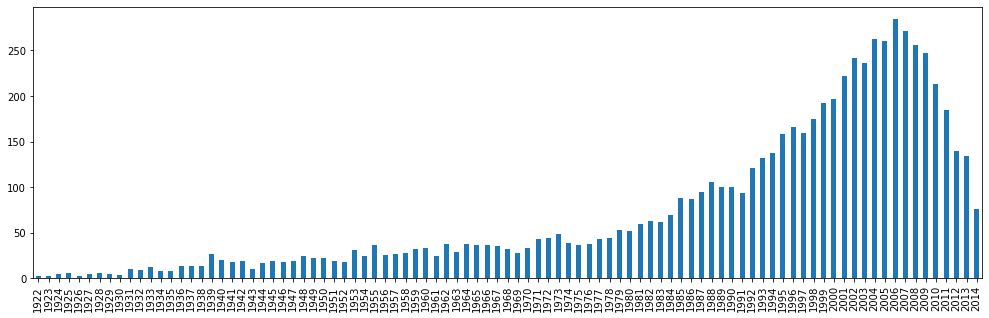

In [32]:
fig, ax = plt.subplots(figsize=(17,5))

year['year'].value_counts().sort_index().plot.bar(ax=ax)

plt.show()

ex) 이 경우에 35번 유저에게 마지막 사용연도(2008년) 보다 한참 후인 2014년의 영화가 추천되는 것이 옳은가?   
(35번 유저가 2014년에는 없는 이탈유저라면..?)

-------

## 생각해볼 점 (2) 영화를 많이 본 유저와 적게 본 유저에게 같은 방법으로 영화추천을 해도 될까?

유저의 영화 시청수를 보게되면 16~2912개 까지 차이가 많이 나는 것을 볼 수 있다   
하지만 평균은 164개로 편향이 심한것을 볼 수 있다

In [33]:
train_rating['user'].value_counts().describe()

count    31360.000000
mean       164.364509
std        150.009107
min         16.000000
25%         71.000000
50%        114.000000
75%        200.000000
max       2912.000000
Name: user, dtype: float64

In [34]:
user_item_count = train_rating.groupby(['user'])['item'].agg('count').values.tolist()

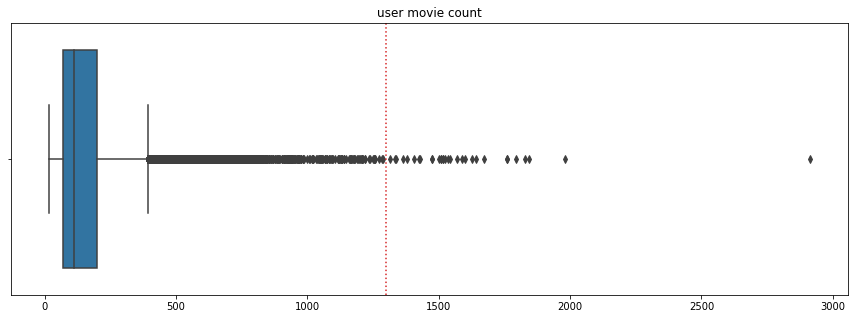

In [35]:
fig, ax = plt.subplots(figsize=(15,5))

sns.boxplot(x=user_item_count, ax=ax)
ax.axvline(x=1300, color='tab:red', ls='dotted')

ax.set_title('user movie count')
plt.show()

이상치에 해당하는 유저(영화를 많이 본 유저)의 수가 많지는 않지만 이런 유저들에게는 다른 기준으로 추천을 해주는 것이 맞지 않을지?   
(이정도로 영화를 많이 봤으면 아무거나 추천해준다던지, content 기반으로 추천을 한다던지, 다른 유저들도 많이본 영화 중 안본걸 추천해준다던지 등)   
또한, 1500개를 본 유저와 500개를 본 유저도 차이점을 둬야할지?

--------------

## 생각해볼 점 (3) 유저들이 많이보지 않은 영화를 추천해 줘도 괜찮을까?

많은 유저들이 본 영화는 유명하거나 대중적으로 선호되는 영화라고 가정할 수 있음   
하지만 본 사람이 적은 영화의 경우에는
1. 대중적이지 않은(인기없는) 영화
2. 개봉한지 얼마 안된 영화   

의 경우로 생각해 볼 수 있음   
2번일 경우에는 상관없지만 이유가 1번일 경우 추천하는데 있어서 고민을 해봐야 할거 같음

In [44]:
print(train_rating['item'].value_counts())
pd.DataFrame(train_rating['item'].value_counts().values).describe()

2571     19699
2959     18437
296      18202
318      18168
356      17339
         ...  
7259        38
126         36
4241        34
2555        34
51372       27
Name: item, Length: 6807, dtype: int64


,0
count,6807.000000
mean,757.230939
std,1682.973090
min,27.000000
25%,90.000000
50%,197.000000
75%,610.500000
max,19699.000000


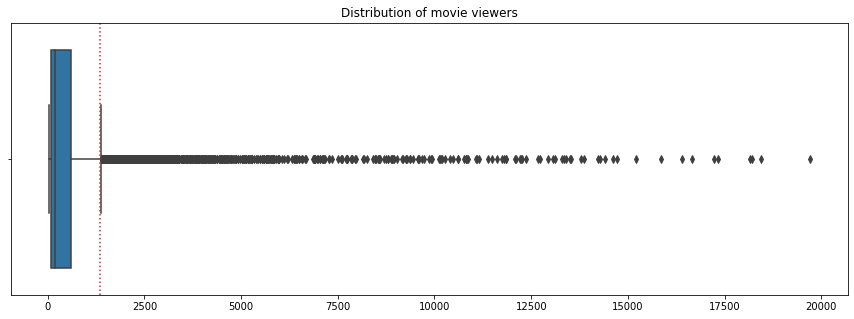

In [58]:
fig, ax = plt.subplots(figsize=(15,5))

sns.boxplot(x=train_rating['item'].value_counts().values, ax=ax)
ax.axvline(x=1350, color='tab:red', ls='dotted')

ax.set_title('Distribution of movie viewers')

plt.show()

대부분의 영화는 1000명 이내의 이용자가 본 것을 알 수 있음   
시청자가 많은 영화는 어떤 것인지 top 10을 한번 확인해보자

In [63]:
top10_movie_ls = train_rating['item'].value_counts()[:10].index

In [79]:
movie_df[movie_df['item'].isin(top10_movie_ls)]

,item,title,year,genre,director,writer
0,318,"Shawshank Redemption, The (1994)",1994,"[Crime, Drama]",[nm0001104],"[nm0000175, nm0001104]"
1,2571,"Matrix, The (1999)",1999,"[Action, Sci-Fi, Thriller]","[nm0905152, nm0905154]","[nm0905152, nm0905154]"
2,2959,Fight Club (1999),1999,"[Action, Crime, Drama, Thriller]",[nm0000399],"[nm0657333, nm0880243]"
3,296,Pulp Fiction (1994),1994,"[Comedy, Crime, Drama, Thriller]",[nm0000233],"[nm0000233, nm0000812]"
4,356,Forrest Gump (1994),1994,"[Comedy, Drama, Romance, War]",[nm0000709],[nm0744839]
5,4993,"Lord of the Rings: The Fellowship of the Ring,...",2001,"[Adventure, Fantasy]",[nm0001392],"[nm0001392, nm0101991, nm0866058, nm0909638]"
6,7153,"Lord of the Rings: The Return of the King, The...",2003,"[Action, Adventure, Drama, Fantasy]",[nm0001392],"[nm0001392, nm0101991, nm0866058, nm0909638]"
7,5952,"Lord of the Rings: The Two Towers, The (2002)",2002,"[Adventure, Fantasy]",[nm0001392],"[nm0001392, nm0101991, nm0801728, nm0866058, n..."
8,593,"Silence of the Lambs, The (1991)",1991,"[Crime, Horror, Thriller]",[nm0001129],"[nm0365383, nm0848217]"
9,2858,American Beauty (1999),1999,"[Comedy, Drama]",[nm0005222],[nm0050332]


영화의 목록을 보니 한번쯤은 들어봤을 법한 유명한 영화라고 볼 수 있음   
이번에는 가장 적게 본 10개를 살펴보자

In [84]:
worst10_movie_ls = train_rating['item'].value_counts()[-10:].index

In [85]:
movie_df[movie_df['item'].isin(worst10_movie_ls)]

,item,title,year,genre,director,writer
3378,27751,'Salem's Lot (2004),2004,"[Drama, Horror, Mystery, Thriller]",[nm0004121],"[nm0000175, nm0276823]"
4236,4241,Pokémon 3: The Movie (2001),2001,"[Animation, Children]",NaN,NaN
4264,1389,Jaws 3-D (1983),1983,"[Action, Horror]",NaN,"[nm0001940, nm0331956, nm0437393, nm0558577]"
4281,2555,Baby Geniuses (1999),1999,[Comedy],[nm0163706],[nm0163706]
4288,126,"NeverEnding Story III, The (1994)",1994,"[Adventure, Children, Fantasy]",[nm0003423],"[nm0003369, nm0256779]"
5053,7259,You Got Served (2004),2004,"[Drama, Musical]",NaN,NaN
5903,414,"Air Up There, The (1994)",1994,[Comedy],[nm0001274],NaN
5974,60007,Doctor Who (1996),1996,"[Adventure, Sci-Fi]",[nm0768249],"[nm0414226, nm0628285]"
6221,117881,Still Alice (2014),2014,[Drama],"[nm0322144, nm0922903]","[nm0322144, nm0922903]"
6488,51372,"""Great Performances"" Cats (1998)",1998,[Musical],NaN,NaN


확실히 top10 과 비교하면 익숙하지 않은 제목의 영화들임을 확인할 수 있음   
이런 영화들을 추천하는거에 대해서는 조금 고민해야될거 같음   
하지만 많은 사람들이 본 영화에 대해서는 추천 우선순위에 고려해도 될거라고 생각함

--------